In [14]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pprint as pp
import random
import seaborn as sns
import decimal
import glob
from collections import OrderedDict

In [15]:
########## select users with indegree zero ###############
def indegZeroUsers(G):
    indeg=list(G.in_degree(G.nodes()))
    in_degree_zero_users = []
    for i in range(0,len(indeg)):
        if indeg[i][1] == 0 :
            in_degree_zero_users.append(indeg[i][0])
    print ('number of indeg zero users ' + str(len(in_degree_zero_users)))
    return in_degree_zero_users
##### save the dataframe if needed #######
#     in_degree_zero_users_df = pd.DataFrame() 
#     in_degree_zero_users_df['users'] = np.array(in_degree_zero_users)
#     in_degree_zero_users_df.to_csv('output/in_degree_zero_users.csv')

In [16]:
############### extracting influence cascades rooted from a given root users list.  ############### 
def inflenceCascadeExtraction(root_list,G):
    actionTypes=['creationTocreation', 'creationTocontribution', 'creationTosharing', 'contributionTocreation', 'contributionTocontribution', 'contributionTosharing', 'sharingTocreation', 'sharingTocontribution', 'sharingTosharing']

    influence_df = pd.DataFrame()
    root_child_df = pd.DataFrame()

    for root in root_list: 

        data=[] # a list contains the influence vectors of users in each levels of hierarchy 

        Queue=[] # a list wich store nodes tempararily 
        hopdists={} # distance from root to nodes. key: node, value: distance from root

        Queue.insert(0,root)    
        hopdists[root] = 0

        while len(Queue) > 0:
            currentNode = Queue.pop()
            hopdist = hopdists[currentNode]

            outEdges = G.out_edges(currentNode,True)
    #         print(outEdges)

            for edge in outEdges:
                influenceVector= [edge[2]['creationTocreation'], edge[2]['creationTocontribution'], edge[2]['creationTosharing'],edge[2]['contributionTocreation'],edge[2]['contributionTocontribution'],edge[2]['contributionTosharing'],edge[2]['sharingTocreation'],edge[2]['sharingTocontribution'],edge[2]['sharingTosharing']]
                child = edge[1]
                if not child in hopdists.keys(): # check whether the node is already counted
                    if len(data) < (hopdist+1):  
                        data.append([])          # create sublists in data list for each hop
                    data[hopdist].append(influenceVector) # store influence vectors of nodes in there corresponding sublist in data list
                    Queue.insert(0,child)                 # add the child node to Queue to cnsider it as a parent node in the next rounds
                    hopdists[child] = hopdist + 1   
  
        
        ##### Characterization of influence vector components #####
        levelInfluenceValues=[zip(*hop) for hop in data]    
        for i in range(len(levelInfluenceValues)):
            levelInfluenceValues[i] = [sum(j) for j in levelInfluenceValues[i]]  # total influence by activity type at each level of the tree 

        level = list(range(1, len(levelInfluenceValues)+1))
        levelInfluenceValues = np.array(levelInfluenceValues).T # total linfluence values at each level by activity type 

        for idx, l in enumerate(levelInfluenceValues):
            m = np.sum(l)
            levelInfluenceValues[idx] = np.array(l) / m  # normalized total influence at each level by activity type   

        this_root_influence_by_levels = {}
        for idx, actiontype in enumerate(actionTypes):
            this_root_influence_by_levels[actiontype]=levelInfluenceValues[idx]
        this_root_influence_by_levels = pd.DataFrame(this_root_influence_by_levels)
        this_root_influence_by_levels["level"]=level 
        this_root_influence_by_levels["root"]=root
        influence_df = influence_df.append(this_root_influence_by_levels,ignore_index=True)  
        
        ##### node-level data extraction of cascades for statistical analysis #######
        cascade_node_data = {'node':list(dict(hopdists).keys()), 'node_level':list(dict(hopdists).values())}
        root_child_by_levels = pd.DataFrame(cascade_node_data)
        root_child_by_levels["root"] = root
        root_child_df = root_child_df.append(root_child_by_levels,ignore_index = True) 

    print('influenceCascades_df')
    print (influence_df.head())
#     influence_df.to_csv('output/influence_df.csv')
#     print (root_child_df.head())
#     root_child_df.to_csv('output/root_child_df.csv')
#     print(influence_df.level.max())
    return influence_df, root_child_df

In [17]:
###### get links and nodes dataframes to create sankey plot using the median influence values of each influence type by level,######

def CreateSankeyLinksAndNodes_dfs(flow_df):   # will return sankey_links_df and sankey_nodes_df
    ############## link data to create sankey plot ###################
    sankey_links_df = flow_df.melt(id_vars=['level'])
    sankey_links_df['from_label'] = sankey_links_df.apply(lambda x: "C" if "contributionTo" in x.variable else ("S" if "sharingTo" in x.variable else "I"),axis=1)
    sankey_links_df['to_label'] = sankey_links_df.apply(lambda x: "C" if "Tocontribution" in x.variable else ("S" if "Tosharing" in x.variable else "I"),axis=1)
    sankey_links_df['from_id_temp'] = (sankey_links_df.level-1).astype(str) + sankey_links_df.from_label
    sankey_links_df['to_id_temp'] = sankey_links_df.level.astype(str) + sankey_links_df.to_label
    #print(sankey_links_df)

    ###### Reassign from_id_temp and to_id_temp with integers. To create sankey plot, nodes ids should be integers######
    node_id = sankey_links_df.drop_duplicates('from_id_temp')[['from_id_temp']]
    node_id = node_id.append(sankey_links_df.drop_duplicates('to_id_temp')[['to_id_temp']])
    node_id['node_id_temp'] = node_id.from_id_temp.combine_first(node_id.to_id_temp)
    node_id = node_id.drop_duplicates('node_id_temp',keep='first').drop(['from_id_temp', 'to_id_temp'], axis = 1)
    node_id['node_id'] = np.arange(len(node_id))

    
    sankey_links_df = pd.merge(sankey_links_df, node_id, how = 'left', left_on='from_id_temp', right_on='node_id_temp',sort = False ).drop(['node_id_temp', 'from_id_temp'], axis = 1).rename(columns = {'node_id': 'from_id'})   #reassign the temp_from_id 
    sankey_links_df = pd.merge(sankey_links_df, node_id, how = 'left', left_on='to_id_temp', right_on='node_id_temp',sort = False ).drop(['node_id_temp','to_id_temp'], axis = 1).rename(columns = {'node_id': 'to_id'}) #reassign the temp_to_id
    sankey_links_df['link_color'] = np.where((sankey_links_df.from_label == "C"), "rgb(144,237,244)", np.where((sankey_links_df.from_label == "I"),"rgb(247,203,81)", "rgb(225,174,242)"))

#     sankey_links_df.to_csv("output/sankey_links_df.csv")
    
    ################## node data to create sankey plot #################

    sankey_nodes_df = sankey_links_df.drop_duplicates("from_id")[["from_id","from_label"]].astype(str)
    sankey_nodes_df = sankey_nodes_df.append(sankey_links_df.drop_duplicates("to_id")[["to_id","to_label"]].astype(str))
    sankey_nodes_df['node_id'] = sankey_nodes_df.from_id.combine_first(sankey_nodes_df.to_id)
    sankey_nodes_df['node_label'] = sankey_nodes_df.from_label.combine_first(sankey_nodes_df.to_label)
    sankey_nodes_df = sankey_nodes_df.drop(['from_id', 'from_label', 'to_id', 'to_label'], axis = 1).drop_duplicates(['node_id', 'node_label'])
    sankey_nodes_df['node_color'] = np.where((sankey_nodes_df.node_label == "C"),"rgb(60,222,234)",np.where((sankey_nodes_df.node_label == "I"),"rgb(232,176,25)", "rgb(213,128,242)"))

    #print(sankey_nodes_df)
#     sankey_nodes_df.to_csv("output/sankey_nodes_df.csv")

    return sankey_links_df,sankey_nodes_df

In [18]:
########################## plotting sankey graph ##############################

def plotSankey(sankey_links_df,sankey_nodes_df):
    import plotly 
    import plotly.plotly as py
    import pandas as pd
    import numpy as np

    #plotly.tools.set_credentials_file(username='username', api_key='api_key')
    data = dict(
        type='sankey',
        arrangement = "freeform",
        opacity = 0.1,
        showlegend = True,
        textfont = dict (
            color = "black",
            size = 1, 
            family = "Droid Serif"      
        ),
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        node = dict(
          pad = 15,
          thickness = 30,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = sankey_nodes_df['node_label'].dropna(axis=0, how='any'),
          color = sankey_nodes_df['node_color'].dropna(axis=0, how='any')
        ),
        link = dict(
          source = sankey_links_df['from_id'],
          target = sankey_links_df['to_id'],
          value = sankey_links_df['value'],
          color = sankey_links_df['link_color'].dropna(axis=0, how='any')
      ))

    layout =  dict(
        #title = "Basic Sankey Diagram",
        height = 1000,
        width = 1800,
        font = dict(
          size = 10
        )
    )

    fig = dict(data=[data], layout=layout)
    py.plot(fig)

In [19]:
#####  Generate scale-free networks with n number of nodes ######
def generateScaleFreeNetworks(n):
    G_scaleFree = nx.scale_free_graph(n, seed=30)# scale free graph with default probabilities (alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, create_using=None,)

    np.random.seed(0)
    def randfloat(x):
        decimal.getcontext().prec = 10  # 10 decimal points enough
        return decimal.Decimal(0) + decimal.Decimal(x)
    # this should include both boundaries as float gets close enough to 1 to make decimal round

    edges = list(set(G_scaleFree.edges()))
    scalefree_network = pd.DataFrame(edges, columns = ["userID1","userID0" ], dtype= str)
    scalefree_network = scalefree_network[scalefree_network["userID0"]!= scalefree_network["userID1"]]
    actionTypes=['creationTocreation', 'creationTocontribution', 'creationTosharing', 'contributionTocreation', 'contributionTocontribution', 'contributionTosharing', 'sharingTocreation', 'sharingTocontribution', 'sharingTosharing']
    for action in actionTypes:
        scalefree_network[action] = np.random.uniform(0,1, scalefree_network.shape[0])
        scalefree_network[action] = scalefree_network[action].apply(lambda x: randfloat(x)).astype(float) 
    scalefree_inflnetwork = scalefree_network[scalefree_network.iloc[:,2:].sum(axis=1) > 0]
    return scalefree_inflnetwork


In [28]:
###### plotting average number of users and rate of connectivity of users by level #######

def userPlots(child_root_df,hue_order_list,colors): # hue_order_list: hue order as a list; colors: colors for elements as a list
    user_count_at_levels = child_root_df.groupby(["platform_community","root","node_level"]).size().reset_index().rename(columns={0:"num_nodes"})
    avg_user_count_at_levels = user_count_at_levels.groupby(["platform_community","node_level"]).mean().reset_index()
    std_user_count_at_levels = user_count_at_levels.groupby(["platform_community","node_level"]).std().reset_index()
    avg_user_count_at_levels["diff"] = avg_user_count_at_levels.groupby("platform_community")["num_nodes"].diff(periods=1)
    avg_user_count_at_levels["cumulative_sum_of_users"]= avg_user_count_at_levels.groupby("platform_community")["num_nodes"].apply(lambda x: x.cumsum())


#     fig, (ax,ax1,ax2,ax3) = plt.subplots(nrows=4,figsize=(10,20))
    fig, (ax,ax2,ax3) = plt.subplots(nrows=3,figsize=(10,20))
    sns.barplot (x="node_level", y="num_nodes", hue = "platform_community",hue_order = hue_order_list,palette=colors,data = avg_user_count_at_levels, ax=ax)
    ax.set_xlabel("Level", fontsize=14)
    ax.set_ylabel("Total Number of Users", fontsize=14)
    plt.setp(ax.get_xticklabels(), rotation=0, fontsize=12)
    plt.setp(ax.get_yticklabels(),fontsize=12)
    plt.legend(fontsize=12)
    
#     sns.barplot (x="node_level", y="cumulative_sum_of_users", hue = "platform_domain",hue_order = hue_order_list,palette=colors,data = avg_user_count_at_levels, ax=ax1)
#     ax1.set_xlabel("Level of Influencees", fontsize=14)
#     ax1.set_ylabel("Cumulative Sum of Influencees", fontsize=14)
#     plt.setp(ax1.get_xticklabels(), rotation=0, fontsize=12)
#     plt.setp(ax1.get_yticklabels(),fontsize=12)
#     plt.legend(fontsize=12)

    sns.lineplot(x=avg_user_count_at_levels["node_level"], y=avg_user_count_at_levels["cumulative_sum_of_users"],hue = "platform_community",hue_order = hue_order_list,palette=colors,data = avg_user_count_at_levels, ax=ax2)
    ax2.grid(True)
    ax2.set_xlabel("Level", fontsize=14)
    ax2.set_ylabel("Cumulative Sum of Users", fontsize=14)
    plt.setp(ax2.get_xticklabels(), rotation=0, fontsize=12)
    plt.setp(ax2.get_yticklabels(),fontsize=12)
    plt.legend(fontsize=12)

    sns.lineplot(x="node_level", y="diff", hue = "platform_community",hue_order = hue_order_list,palette=colors,data = avg_user_count_at_levels, ax=ax3)
    ax3.grid(True)
    ax3.set_xlabel("Level of Influencees", fontsize=14)
    ax3.set_ylabel("Rate of Change of Total Number of Influencees", fontsize=14)
    plt.setp(ax3.get_xticklabels(), rotation=0, fontsize=12)
    plt.setp(ax3.get_yticklabels(),fontsize=12)
    plt.legend(fontsize=12)

#     plt.savefig("/home/social-sim/hierarchy/influence_hierarchical_structures/Untitled Folder/output/user_plots.png")
    plt.show()

In [21]:
platforms = ["GitHub","Twitter"]
communities = ["Crypto","CVE"]
empirical_inflcascades_df = pd.DataFrame()
empirical_rootchild_df = pd.DataFrame()
empirical_inflnetworks_nodecount = OrderedDict()
scalefree_inflcascades_df = pd.DataFrame()
scalefree_rootchild_df = pd.DataFrame()

for platform in platforms:
    for community in communities:
        platform_community = str(platform)+"_"+str(community)
        inflnetwork_gt=pd.read_csv("input_data/"+platform_community+"_Influence_Network_df.csv")
        print (platform_community)
        G=nx.from_pandas_edgelist(inflnetwork_gt,'userID0','userID1',inflnetwork_gt.columns.tolist()[2:],
                                   create_using=nx.DiGraph())
        empirical_inflnetworks_nodecount[platform_community] = G.number_of_nodes()
        indeg_zero_users = indegZeroUsers(G) # finding in-degree zero nodes (source nodes) in the influence network
        inflcascades_df, root_child_df = inflenceCascadeExtraction(indeg_zero_users,G) # extracting influence cascades of source nodes
        gt_infl_medians_by_level_and_type_df = inflcascades_df.groupby(by=["level"]).median().fillna(0).reset_index() #taking the median of noramlized total influence vector components 
        sankey_links_df,sankey_nodes_df = CreateSankeyLinksAndNodes_dfs(gt_infl_medians_by_level_and_type_df) # creating nodes and flow(links) dataframes for visualization 
        plotSankey(sankey_links_df,sankey_nodes_df) # plotting influence cascades through Sankey diagram
        
        #### storing influence cascades dfs and root_child dfs for statistical analysis ###### 
        inflcascades_df["platform"] = platform
        inflcascades_df["community"] = community
        empirical_inflcascades_df = empirical_inflcascades_df.append(inflcascades_df)
        root_child_df["platform"] = platform
        root_child_df["community"] = community
        root_child_df["platform_community"] = platform_community
        empirical_rootchild_df = empirical_rootchild_df.append(root_child_df)
        
        #### comparison with scale-free networks ######
        scalefree_inflnetwork = generateScaleFreeNetworks(G.number_of_nodes()) #generating scale-free networks with equal number of nodes in empirical network
#         scalefree_inflnetwork.to_csv(str(platform_community)+"_SF_Influence_Network_df.csv", index = False)  # saving the influence naetwork data of scale-free networks if needed
        G_SF = nx.from_pandas_edgelist(scalefree_inflnetwork,'userID0','userID1',inflnetwork_gt.columns.tolist()[2:],
                                   create_using=nx.DiGraph())
        indeg_zero_users_SF = indegZeroUsers(G_SF) # finding in-degree zero nodes (source nodes) in the influence network
        inflcascades_df_SF, root_child_df_SF = inflenceCascadeExtraction(indeg_zero_users_SF,G_SF) # extracting influence cascades of source nodes
        SF_infl_medians_by_level_and_type_df = inflcascades_df_SF.groupby(by=["level"]).median().fillna(0).reset_index() #taking the median of noramlized total influence vector components 
        SF_sankey_links_df,SF_sankey_nodes_df = CreateSankeyLinksAndNodes_dfs(SF_infl_medians_by_level_and_type_df) # creating nodes and flow(links) dataframes for visualization
        plotSankey(SF_sankey_links_df,SF_sankey_nodes_df) # plotting influence cascades through Sankey diagram
        
        #### Storing influence cascades dfs of scale-free networks for statistical analysis #####
        inflcascades_df_SF["platform"] = platform
        inflcascades_df_SF["community"] = community
        scalefree_inflcascades_df = inflcascades_df_SF.append(inflcascades_df_SF)
        root_child_df_SF["platform"] = platform
        root_child_df_SF["community"] = community
        root_child_df_SF["platform_community"] = "SF_"+ str(platform_community)
        scalefree_rootchild_df = scalefree_rootchild_df.append(root_child_df_SF)
        
        
empirical_inflcascades_df.to_csv("empirical_influence_cascades_df.csv", index=False)
empirical_rootchild_df.to_csv("empirical_rootchild_df.csv",index=False)
scalefree_inflcascades_df.to_csv("scalefree_influence_cascades_df.csv", index=False)
scalefree_rootchild_df.to_csv("scalefree_rootchild_df.csv", index=False)
        



GitHub_Crypto
number of indeg zero users 568


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0                 0.0                     0.0                NaN   
1                 1.0                     1.0                NaN   
2                 0.0                     0.0                NaN   
3                 0.0                     0.0                NaN   
4                 1.0                     1.0                NaN   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0                0.000000                    0.024282               0.000000   
1                1.000000                    0.942253               0.903609   
2                0.000000                    0.033464               0.096391   
3                0.000000                    0.020674               0.000000   
4                0.970825                    0.872838               0.696630   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0                

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0                 NaN                     NaN                NaN   
1                 NaN                     NaN                NaN   
2                 NaN                     NaN                NaN   
3                 NaN                     NaN                NaN   
4                 NaN                     NaN                NaN   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0                     NaN                    0.005364                    0.0   
1                     NaN                    0.557443                    1.0   
2                     NaN                    0.357710                    0.0   
3                     NaN                    0.062333                    0.0   
4                     NaN                    0.017149                    0.0   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0                

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0            0.000000                0.000000           0.000000   
1            1.000000                0.980239           0.997837   
2            0.000000                0.019761           0.002163   
3            0.000000                0.000000           0.000000   
4            0.989963                0.926445           0.976918   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0                0.462185                    0.230130               0.154804   
1                0.537815                    0.769870               0.845196   
2                0.000000                    0.000000               0.000000   
3                0.028594                    0.118620               0.099755   
4                0.951029                    0.569465               0.821245   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0           0.289

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0            0.625103                     1.0           0.277282   
1            0.184380                     0.0           0.205079   
2            0.190517                     0.0           0.517639   
3            0.000000                     0.0           0.000000   
4            0.889459                     1.0           1.000000   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0                     0.0                         NaN                    0.0   
1                     1.0                         NaN                    1.0   
2                     0.0                         NaN                    0.0   
3                     NaN                         NaN                    0.0   
4                     NaN                         NaN                    0.0   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0           0.000

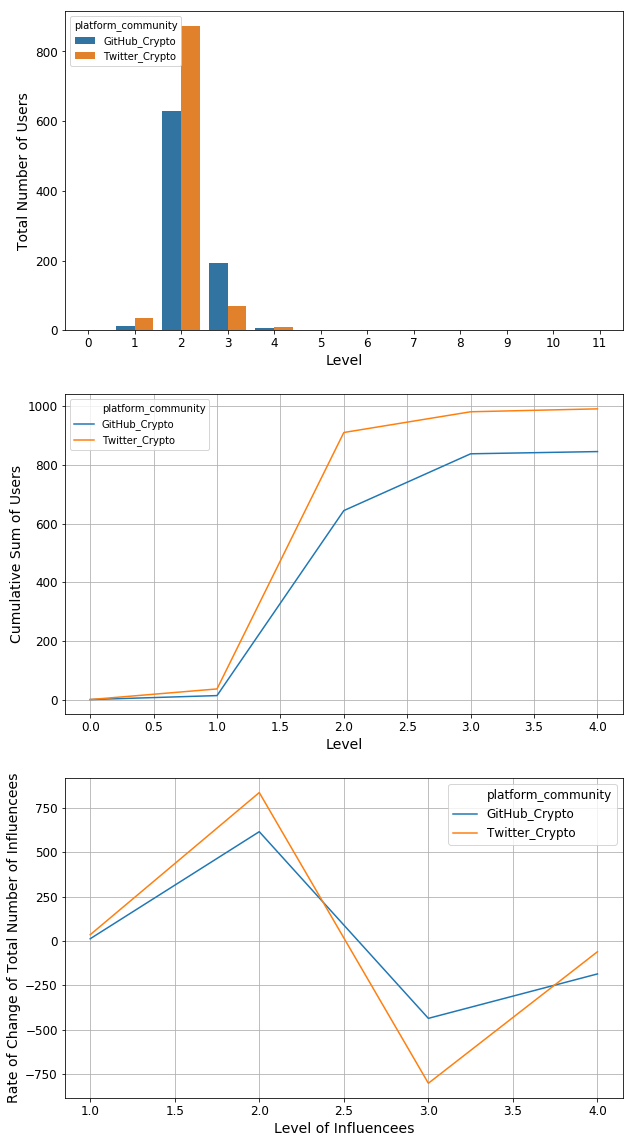

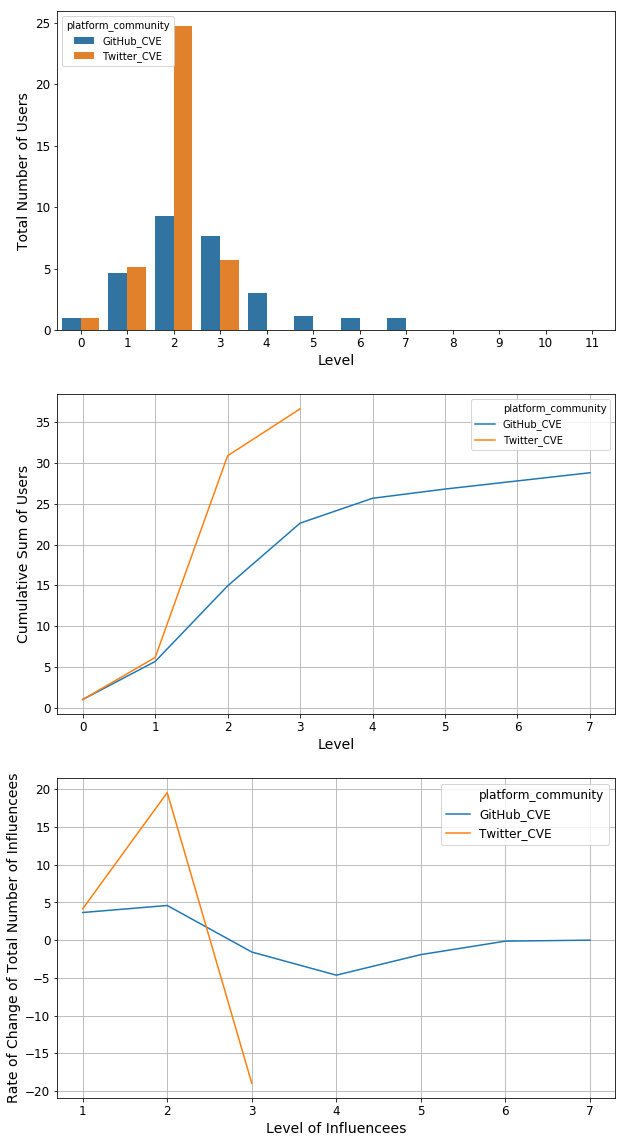

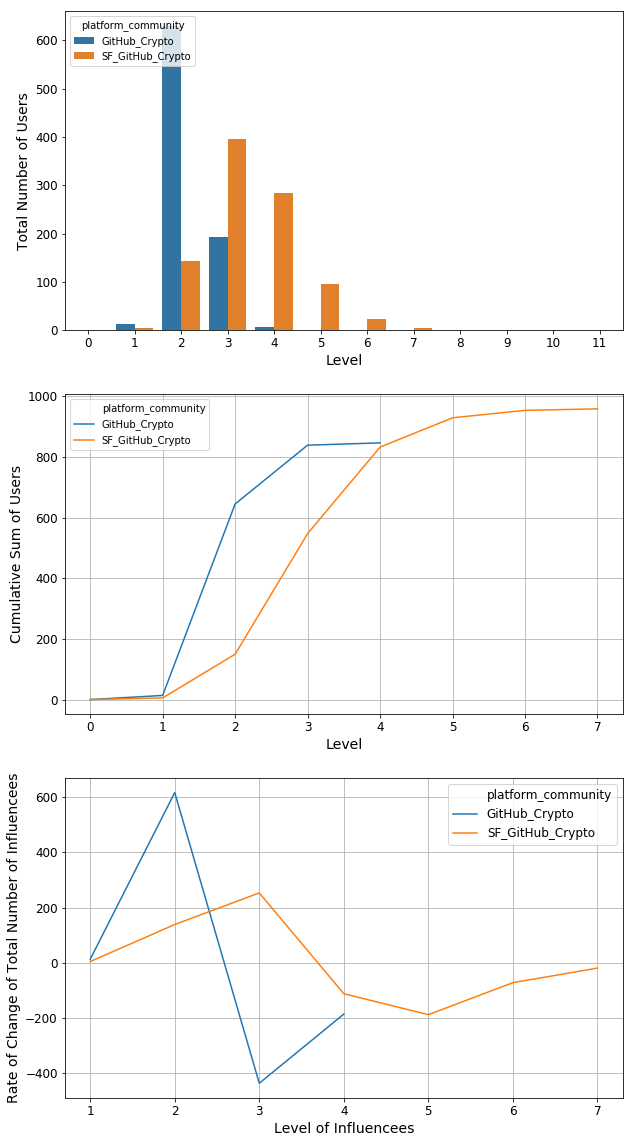

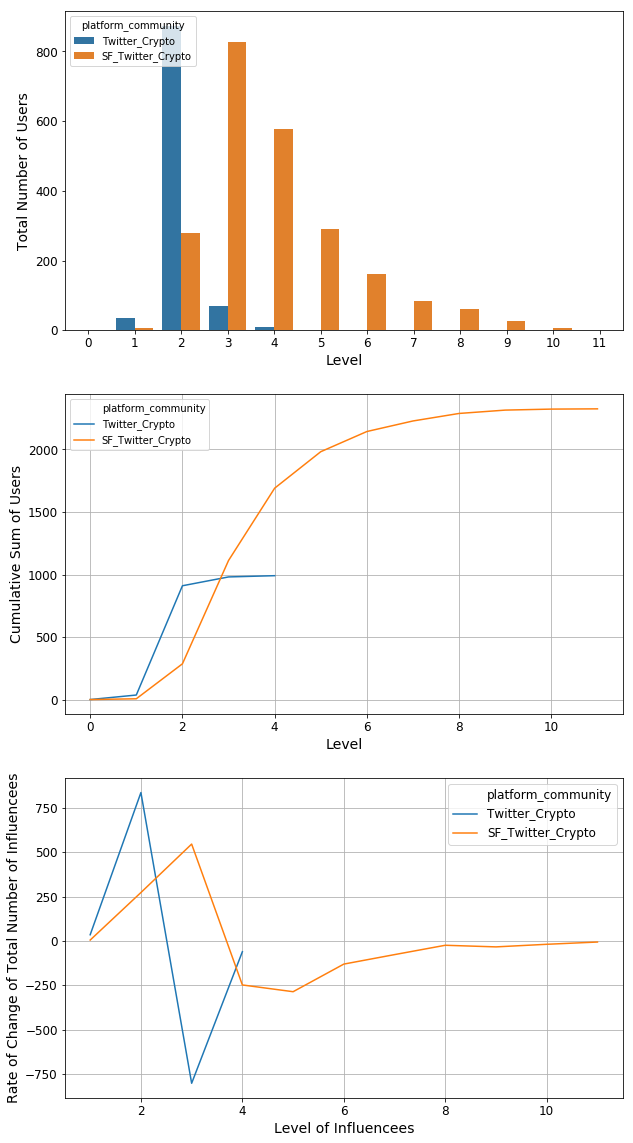

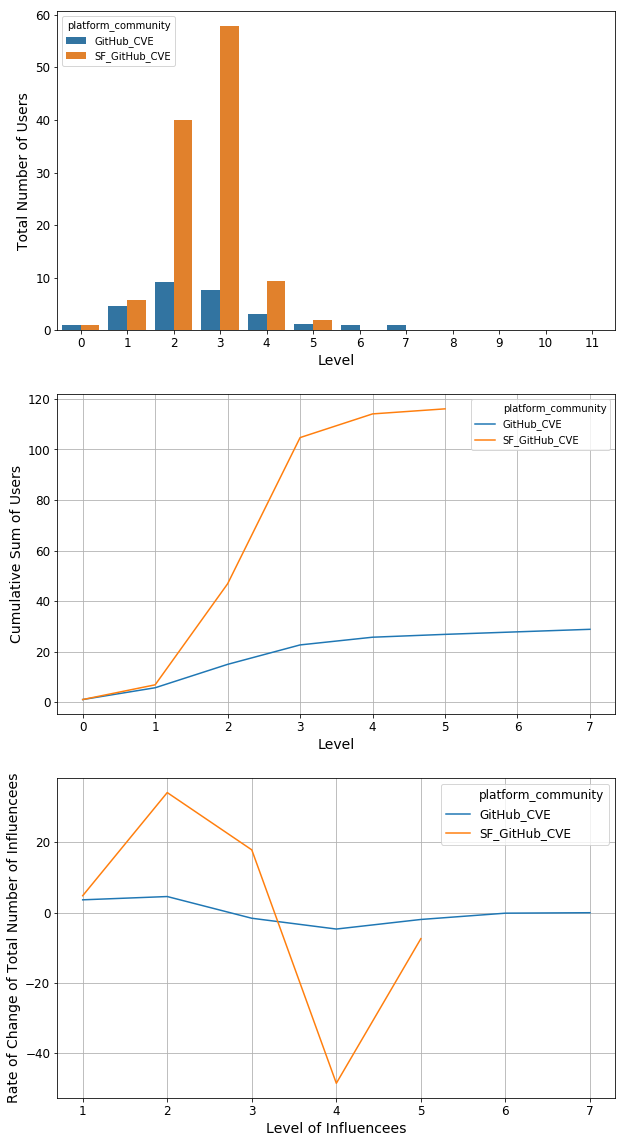

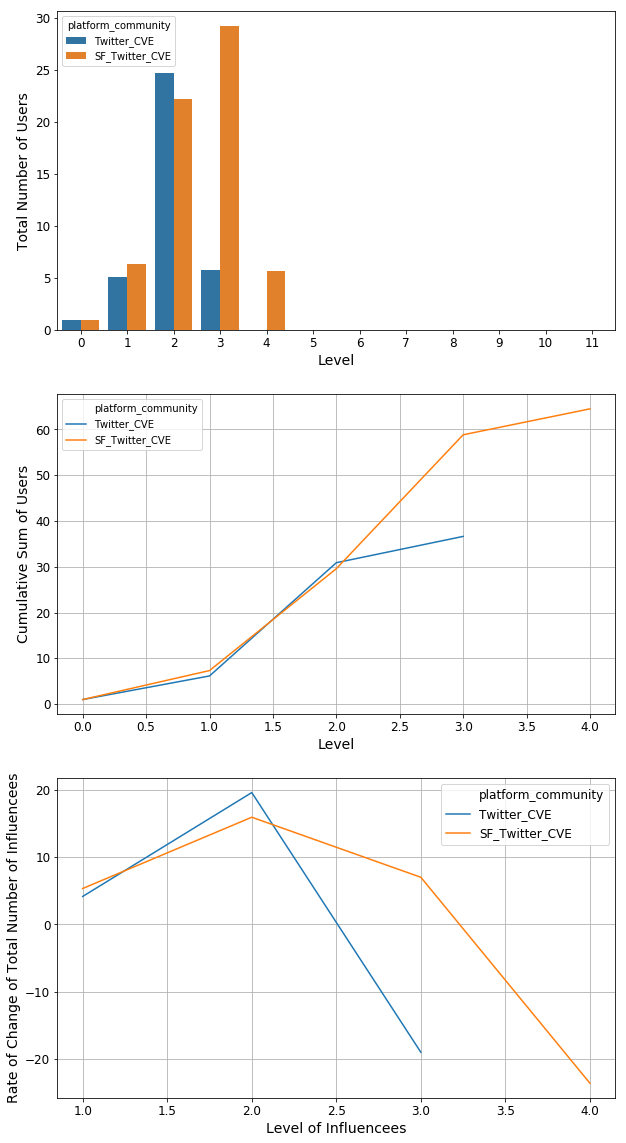

In [30]:
#### Plotting user distribution/connectivity graphs #####
rootchild_data = pd.concat([empirical_rootchild_df,scalefree_rootchild_df], axis=0)
#Comparisons by platforms #
userPlots(rootchild_data,["GitHub_Crypto", "Twitter_Crypto"],["C0", "C1"]) 
userPlots(rootchild_data,["GitHub_CVE","Twitter_CVE"],["C0", "C1"]) 
#Comparisons of platform_community vs scale-free #
userPlots(rootchild_data,["GitHub_Crypto","SF_GitHub_Crypto"],["C0", "C1"])
userPlots(rootchild_data,["Twitter_Crypto","SF_Twitter_Crypto"],["C0", "C1"])
userPlots(rootchild_data,["GitHub_CVE","SF_GitHub_CVE"],["C0", "C1"])
userPlots(rootchild_data,["Twitter_CVE","SF_Twitter_CVE"],["C0", "C1"])


